# Проект "Промышленность" #

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.



### Описание этапа обработки ###


Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.


Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).


Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.


Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).



### Описание данных ###

Данные состоят из файлов, полученных из разных источников:
- **data_arc_new.csv** — данные об электродах;
- **data_bulk_new.csv** — данные о подаче сыпучих материалов (объём);
- **data_bulk_time_new.csv** — данные о подаче сыпучих материалов (время);
- **data_gas_new.csv** — данные о продувке сплава газом;
- **data_temp_new.csv** — результаты измерения температуры;
- **data_wire_new.csv** — данные о проволочных материалах (объём);
- **data_wire_time_new.csv** — данные о проволочных материалах (время).

Во всех файлах столбец *key* содержит номер партии. В файлах может быть несколько строк с одинаковым значением *key*: они соответствуют разным итерациям обработки.

## Исследовательский анализ и предобработка данных ##

Загрузим все необходимые нам библиотеки.

In [84]:
#pip install xgboost

In [85]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb

from datetime import timedelta
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, SGDRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 140823

Откроем файлы и изучим всю информацию по ним.

In [86]:
try:
    data_arc_new = pd.read_csv('data_arc_new.csv')
    data_bulk_new = pd.read_csv('data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('data_gas_new.csv')
    data_temp_new = pd.read_csv('data_temp_new.csv')
    data_wire_new = pd.read_csv('data_wire_new.csv')
    data_wire_time_new = pd.read_csv('data_wire_time_new.csv')
except:
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')

Для удобства напишем функцию для изучения данных, затем последовательно изучим данные в каждой таблице, построим необходимые графики и напишем план по дальнейшей предобработке данных. 

In [87]:
def show_all_info(df):
    print('Первые 10 строк:')
    display(df.head(10))
    print('Основная информация:')
    display(df.info())
    print('Количество уникальных значений key:', df['key'].nunique())
    print('Описательная статистика:')
    display(df.describe())
    print("Количество пропусков:")
    display(df.isna().sum())
    print(f'Количество дубликатов: {df.duplicated().sum()}\n')

Далее, будем проводить анализ каждой таблицы и в конце писать план для ее предобработки, затем сразу же ее проводить. После анализа и предобработки напишем общий вывод и также дальнейшие планы по объединению таблицы, или же введения новых признаков (если потребуется).

### data_arc_new.csv — данные об электродах. ###

Итак, начнем по порядку с таблицы *data_arc_new*.

In [88]:
show_all_info(data_arc_new)

Первые 10 строк:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

Количество уникальных значений key: 3214
Описательная статистика:


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Количество пропусков:


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Количество дубликатов: 0



Построим графики распределения мощностей.

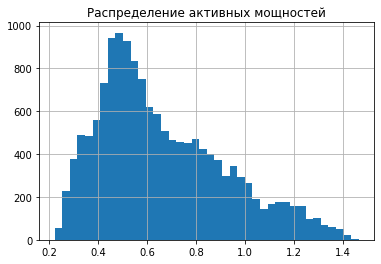

In [89]:
plt.hist(x=data_arc_new['Активная мощность'], histtype='bar', bins=40)
plt.grid(True)
plt.title('Распределение активных мощностей')
plt.show()

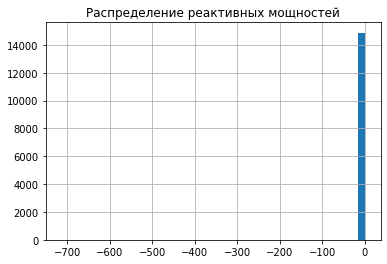

In [90]:
plt.hist(x=data_arc_new['Реактивная мощность'], histtype='bar', bins=40)
plt.grid(True)
plt.title('Распределение реактивных мощностей')
plt.show()

Судя по описательной статистике и распределению реактивных мощностей у нас есть аномальные значения в стоблце *Реактивная мощность*. Высним, сколько их.

In [91]:
data_arc_new[data_arc_new['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Итак, у нас всего один аномальный (отрицательный) выброс, поэтому я предлагаю удалить всю партию под номером **2116** из данной таблицы и снова построить график.

In [92]:
data_arc_new = data_arc_new[data_arc_new['key'] != 2116]
data_arc_new.reset_index(drop=True , inplace=True)

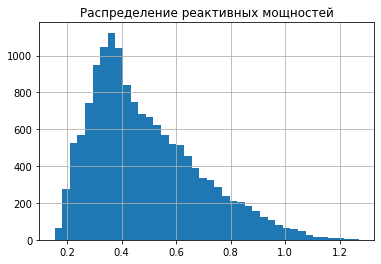

In [93]:
plt.hist(x=data_arc_new['Реактивная мощность'], histtype='bar', bins=40)
plt.grid(True)
plt.title('Распределение реактивных мощностей')
plt.show()

Оба расределения являются нормальными со сдвигом вправо.

Также построим диаграммы размаха мощностей:

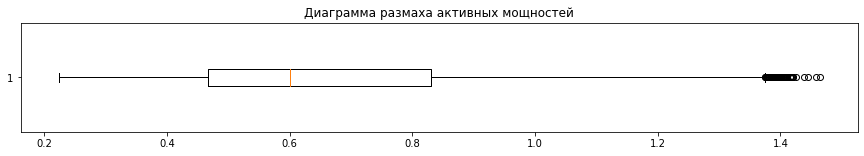

In [94]:
plt.figure(figsize=(15,2))
plt.boxplot(x=data_arc_new['Активная мощность'], vert=False)
plt.title('Диаграмма размаха активных мощностей')
plt.show()

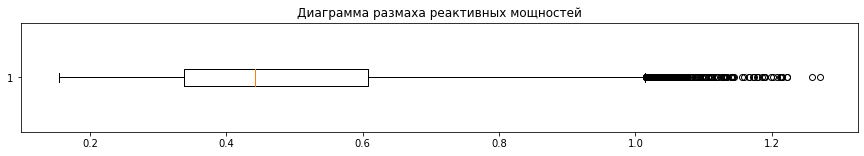

In [95]:
plt.figure(figsize=(15,2))
plt.boxplot(x=data_arc_new['Реактивная мощность'], vert=False)
plt.title('Диаграмма размаха реактивных мощностей')
plt.show()

In [96]:
data_arc_new.describe()

,key,Активная мощность,Реактивная мощность
count,14872.000000,14872.000000,14872.000000
mean,1615.085732,0.662753,0.487112
std,934.661090,0.258916,0.197623
min,1.000000,0.223120,0.153777
25%,806.000000,0.467114,0.337175
50%,1616.000000,0.599587,0.441667
75%,2429.000000,0.830314,0.608201
max,3241.000000,1.463773,1.270284


Мы видим, что выбросы присутствуют, но они не аномальны, т.е. получившиеся значения мощностей реальны и не вызваны, например, ошибкой измерения прибором. Поэтому на данном этапе мы не будем их обрабатывать.

**План для *data_arc_new*:**

- Переименовать все столбцы, избавиться от кириллицы;
- Привести столбцы *Начало/Конец нагрева дугой* к datetime64;
- Обработать аномальные значения в столбце *Реактивная мощность* (уже сделали выше).

In [97]:
data_arc_new.columns = ['key', 'heating_start', 'heating_end', 'active_power', 'reactive_power']

data_arc_new['heating_start'] = pd.to_datetime(data_arc_new['heating_start'])
data_arc_new['heating_end'] = pd.to_datetime(data_arc_new['heating_end'])

In [98]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14872 entries, 0 to 14871
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14872 non-null  int64         
 1   heating_start   14872 non-null  datetime64[ns]
 2   heating_end     14872 non-null  datetime64[ns]
 3   active_power    14872 non-null  float64       
 4   reactive_power  14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.1 KB


In [99]:
data_arc_new.head(10)

,key,heating_start,heating_end,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


### data_bulk_new.csv и data_bulk_time_new.csv — данные о подаче сыпучих материалов (объём и время) ###

In [100]:
show_all_info(data_bulk_new)

Первые 10 строк:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

Количество уникальных значений key: 3129
Описательная статистика:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Количество пропусков:


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Количество дубликатов: 0



In [101]:
show_all_info(data_bulk_time_new)

Первые 10 строк:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

Количество уникальных значений key: 3129
Описательная статистика:


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Количество пропусков:


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Количество дубликатов: 0



Как мы видим, структура таблиц полностью идентична. Пропуски говорят нам о том, что тот или иной сыпучий материал Bulk не добавлялся в тот или иной момент времени.

**План для *data_bulk_new*:**

- Привести к змеиному регистру названия столбцов;
- Заполнить пропуски нулями;
- Перевести типы данных всех столбцов к int;
- Построить столбчатую диаграмму и решить, нужно ли оставлять те сыпучие материалы, которые использовались не так часто;
- Построить диаграмму размаха и обработать выбросы.

In [102]:
data_bulk_new.columns = data_bulk_new.columns.str.lower()
data_bulk_new.columns = data_bulk_new.columns.str.replace(' ', '_')

In [103]:
data_bulk_new = data_bulk_new.fillna(0)

In [104]:
data_bulk_new = data_bulk_new.astype('int')

In [105]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      3129 non-null   int64
 1   bulk_1   3129 non-null   int64
 2   bulk_2   3129 non-null   int64
 3   bulk_3   3129 non-null   int64
 4   bulk_4   3129 non-null   int64
 5   bulk_5   3129 non-null   int64
 6   bulk_6   3129 non-null   int64
 7   bulk_7   3129 non-null   int64
 8   bulk_8   3129 non-null   int64
 9   bulk_9   3129 non-null   int64
 10  bulk_10  3129 non-null   int64
 11  bulk_11  3129 non-null   int64
 12  bulk_12  3129 non-null   int64
 13  bulk_13  3129 non-null   int64
 14  bulk_14  3129 non-null   int64
 15  bulk_15  3129 non-null   int64
dtypes: int64(16)
memory usage: 391.2 KB


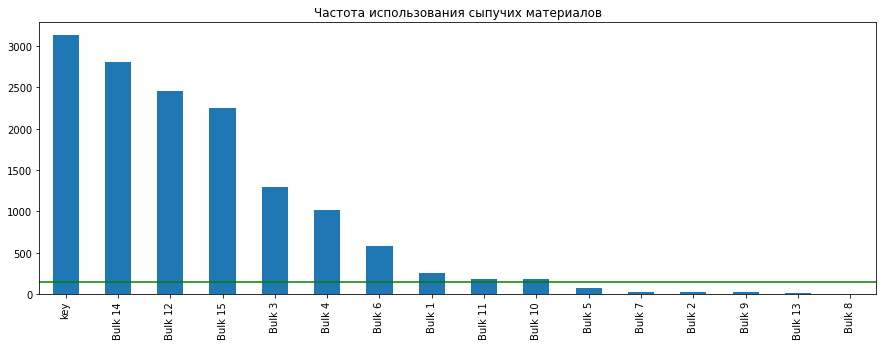

In [106]:
(data_bulk_time_new.count()).sort_values(ascending=False).plot(kind = 'bar', figsize = (15,5)).axhline(y=150, color='g', linestyle='-')
plt.title('Частота использования сыпучих материалов')
plt.show()

Мы видим, что сыпучие материалы Bulk под номерами 5, 7, 2, 9, 13, 8 использовались очень редко (реже 150 раз, т.е. реже 5% от общего числа партий) и данных по ним недостаточно. Возможно стоит их отбросить перед обучением наших моделей, но пока что делать этого не будем.

Построим диаграмму размаха и удалим выбросы.

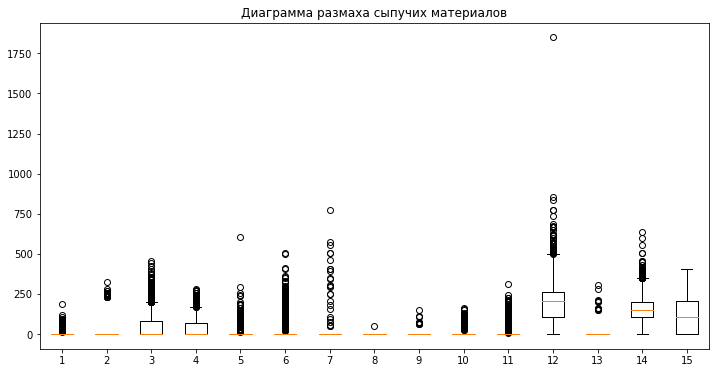

In [107]:
plt.figure(figsize=(12,6))
plt.boxplot(x=data_bulk_new.iloc[:, 1:16])
plt.title('Диаграмма размаха сыпучих материалов')
plt.show()

In [108]:
data_bulk_new = data_bulk_new[data_bulk_new['bulk_12']<1500]
data_bulk_new = data_bulk_new[data_bulk_new['bulk_5']<500]

Таблицу *data_bulk_time_new* предобрабатывать не будем, поскольку она не понадобится для обучения моделей.

### **data_gas_new.csv** — данные о продувке сплава газом ###

In [109]:
show_all_info(data_gas_new)

Первые 10 строк:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Количество уникальных значений key: 3239
Описательная статистика:


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Количество пропусков:


key      0
Газ 1    0
dtype: int64

Количество дубликатов: 0



Построим также гистограмму и диаграмму размаха. 

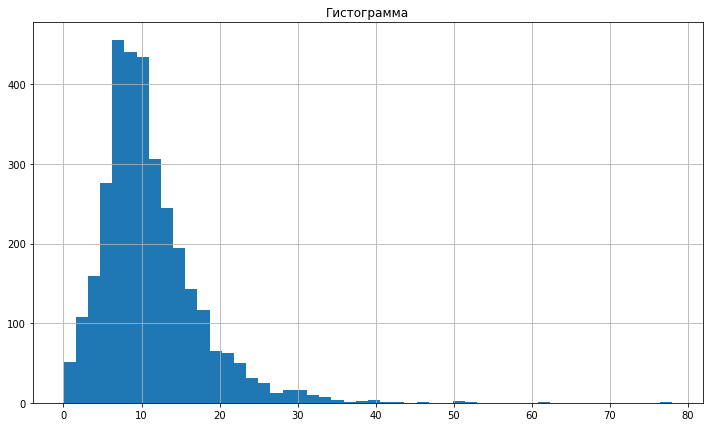

In [110]:
plt.figure(figsize=(12,7))
plt.hist(x=data_gas_new['Газ 1'], bins=50, histtype='bar')
plt.grid(True)
plt.title('Гистограмма')
plt.show()

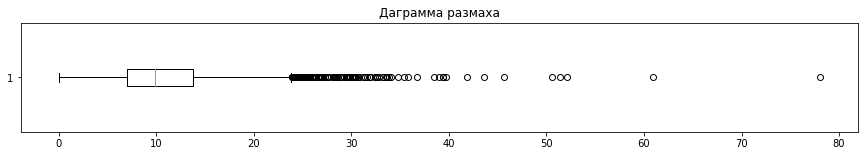

In [111]:
plt.figure(figsize=(15,2))
plt.boxplot(x=data_gas_new['Газ 1'], vert=False)
plt.title('Даграмма размаха')
plt.show()

Распределение похоже на нормальное с небольшим смещением вправо. Также по графикам выше мы видим, что у нас есть выбросы, часть из которых можно считать аномальными.

**План для *data_gas_new*:**

- Переименовать столбец *Газ 1*;
- Удалить аномальные выбросы при значении в столбце *Газ 1* выше 50, посмотреть как изменятся данные после этого.

In [112]:
data_gas_new.columns = ['key', 'gas']

In [113]:
data_gas_new = data_gas_new[data_gas_new['gas']<50]

In [114]:
data_gas_new.reset_index(drop=True, inplace=True)

In [115]:
data_gas_new.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [116]:
data_gas_new.describe()

,key,gas
count,3234.000000,3234.000000
mean,1622.699443,10.928461
std,934.969652,5.922425
min,1.000000,0.008399
25%,814.250000,7.038335
50%,1622.500000,9.825443
75%,2431.750000,13.754024
max,3241.000000,45.638999


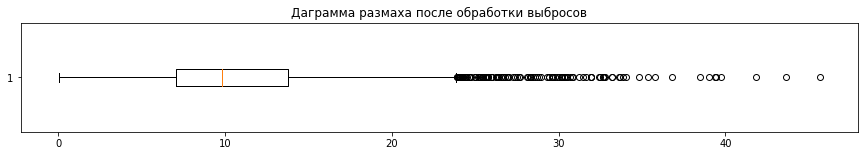

In [117]:
plt.figure(figsize=(15,2))
plt.boxplot(x=data_gas_new['gas'], vert=False)
plt.title('Даграмма размаха после обработки выбросов')
plt.show()

Мы удалили лишь 5 аномальных выброса, данные стали выглядеть лучше.

### data_temp_new.csv — результаты измерения температуры ###

In [118]:
show_all_info(data_temp_new)

Первые 10 строк:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

Количество уникальных значений key: 3216
Описательная статистика:


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


Количество пропусков:


key                0
Время замера       0
Температура     3427
dtype: int64

Количество дубликатов: 0



Итак, мы добрались до нашего целевого признака - **температура плавления последнего замера партии**.

**План для *data_temp_new*:**

- Переименовать столбцы, привести их к змеиному регистру;
- Удалить все пропуски;
- Привести столбец *Время замера* к datetime64, а столбец Температур к int;
- Построить диаграммы, изучить выбросы и удалить их;
- оставить только те партии, где есть хотя бы 2 замера;
- оставить только начальное и конечное значение замеров температуры, остальные отбросить, при этом конечный замер это и будет целевой признак, начальный замер отнесем к признакам.

In [119]:
data_temp_new.columns = ['key', 'measurement_time', 'temperature']

data_temp_new['measurement_time'] = pd.to_datetime(data_temp_new['measurement_time'])

In [120]:
data_temp_new = data_temp_new.dropna()

In [121]:
data_temp_new['temperature'] = data_temp_new['temperature'].astype('int')

In [122]:
data_temp_new.reset_index(drop=True , inplace=True)

In [123]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14665 entries, 0 to 14664
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               14665 non-null  int64         
 1   measurement_time  14665 non-null  datetime64[ns]
 2   temperature       14665 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 343.8 KB


Перейдем к уже знакомым гистограмме и ящику с усами.

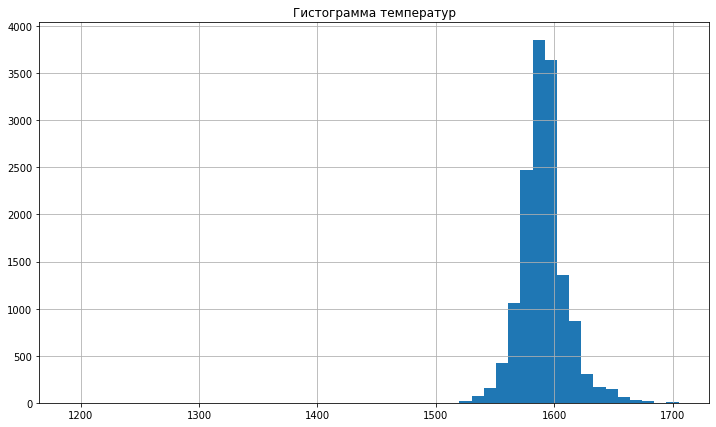

In [124]:
plt.figure(figsize=(12,7))
plt.hist(x=data_temp_new['temperature'], bins=50, histtype='bar')
plt.grid(True)
plt.title('Гистограмма температур')
plt.show()

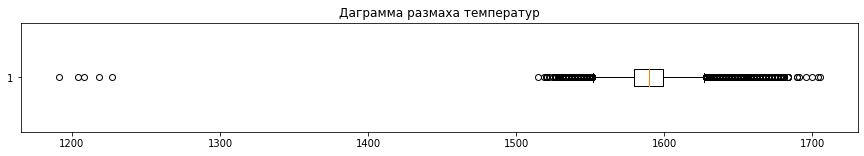

In [125]:
plt.figure(figsize=(15,2))
plt.boxplot(x=data_temp_new['temperature'], vert=False)
plt.title('Даграмма размаха температур')
plt.show()

Итак, судя по графику у нас довольно много выбросов. В глаза бросаются аномальные выбросы (температура плавления ниже 1400C), сразу же отбросим их.

In [126]:
data_temp_new = data_temp_new[data_temp_new['temperature']>1400]

In [127]:
data_temp_new.reset_index(drop=True , inplace=True)

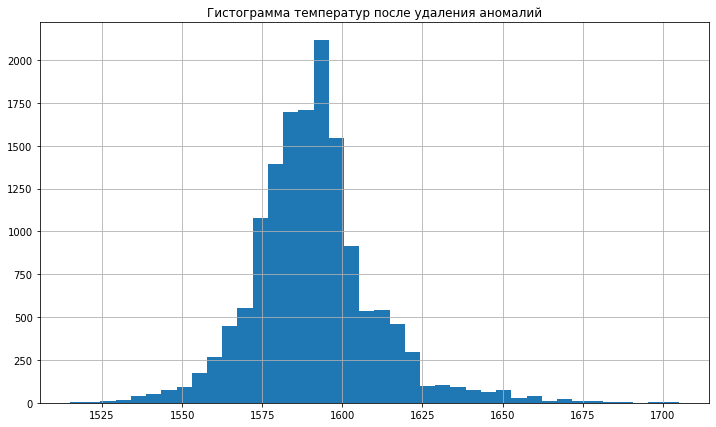

In [128]:
plt.figure(figsize=(12,7))
plt.hist(x=data_temp_new['temperature'], bins=40, histtype='bar')
plt.grid(True)
plt.title('Гистограмма температур после удаления аномалий')
plt.show()

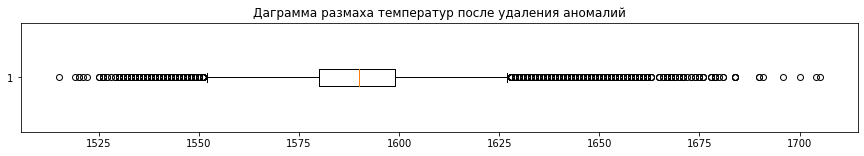

In [129]:
plt.figure(figsize=(15,2))
plt.boxplot(x=data_temp_new['temperature'], vert=False)
plt.title('Даграмма размаха температур после удаления аномалий')
plt.show()

In [130]:
data_temp_new.describe()

,key,temperature
count,14660.000000,14660.000000
mean,1325.369236,1590.852729
std,787.407873,19.143141
min,1.000000,1515.000000
25%,654.000000,1580.000000
50%,1314.000000,1590.000000
75%,1962.250000,1599.000000
max,3241.000000,1705.000000


In [131]:
data_temp_new['key'].value_counts()

2108    17
1513    16
1689    16
46      14
322     14
        ..
3236     1
2963     1
2955     1
2947     1
2525     1
Name: key, Length: 3215, dtype: int64

In [132]:
sub_data_temp_new = data_temp_new[data_temp_new.groupby('key').key.transform('count')>1].copy()

In [133]:
sub_data_temp_new['key'].value_counts(ascending=True)

556      2
1974     2
112      2
343      2
1619     2
        ..
46      14
322     14
1689    16
1513    16
2108    17
Name: key, Length: 2475, dtype: int64

Создадим сводную таблицу со значениями температур первого и последнего замера партии.

In [134]:
data_temp = sub_data_temp_new.groupby('key', as_index=False).agg(start_temp=('temperature', 'first'), last_temp=('temperature', 'last'))
data_temp.head()

,key,start_temp,last_temp
0,1,1571,1613
1,2,1581,1602
2,3,1596,1599
3,4,1601,1625
4,5,1576,1602


In [135]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   key         2475 non-null   int64
 1   start_temp  2475 non-null   int64
 2   last_temp   2475 non-null   int64
dtypes: int64(3)
memory usage: 77.3 KB


Итак, в итоге мы получили таблицу с первым и последним замером температур, которая в будущем нам пригодится для объединения признаков.

### data_wire_new.csv и data_wire_time_new.csv — данные о проволочных материалах (объём и время) ###

In [136]:
show_all_info(data_wire_new)

Первые 10 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Количество уникальных значений key: 3081
Описательная статистика:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Количество пропусков:


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Количество дубликатов: 0



In [137]:
show_all_info(data_wire_time_new)

Первые 10 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

Количество уникальных значений key: 3081
Описательная статистика:


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Количество пропусков:


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Количество дубликатов: 0



Мы можем наблюдать похожую картину, как и в случае с сыпучими материалами. Проведем точно такие же действия.

Cтруктура таблиц полностью идентична. Пропуски говорят нам о том, что тот или иной сыпучий материал Wire не добавлялся в тот или иной момент времени.

План для **data_wire_new**:

- Привести к змеиному регистру названия столбцов;
- Заполнить пропуски нулями;
- Перевести типы данных всех столбцов к int;
- Построить столбчатую диаграмму и решить, нужно ли оставлять те проволочные материалы, которые использовались не так часто;
- Построить диаграмму размаха и обработать выбросы.

In [138]:
data_wire_new.columns = data_wire_new.columns.str.lower()
data_wire_new.columns = data_wire_new.columns.str.replace(' ', '_')

In [139]:
data_wire_new = data_wire_new.fillna(0)

In [140]:
data_wire_new = data_wire_new.astype('int')

In [141]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   key     3081 non-null   int64
 1   wire_1  3081 non-null   int64
 2   wire_2  3081 non-null   int64
 3   wire_3  3081 non-null   int64
 4   wire_4  3081 non-null   int64
 5   wire_5  3081 non-null   int64
 6   wire_6  3081 non-null   int64
 7   wire_7  3081 non-null   int64
 8   wire_8  3081 non-null   int64
 9   wire_9  3081 non-null   int64
dtypes: int64(10)
memory usage: 240.8 KB


Построим столбчатую диаграмму.

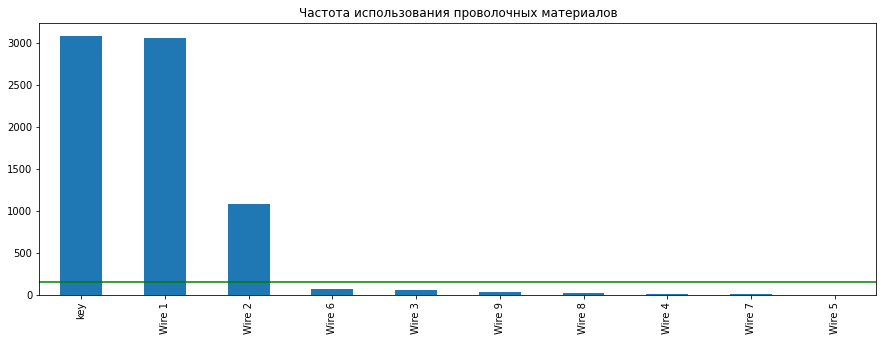

In [142]:
(data_wire_time_new.count()).sort_values(ascending=False).plot(kind = 'bar', figsize = (15,5)).axhline(y=150, color='g', linestyle='-')
plt.title('Частота использования проволочных материалов')
plt.show()

Мы видим, что проволочные материалы Wire под номерами 6, 3, 9, 8, 4, 7, 5 использовались очень редко (реже 150 раз, т.е. реже 5% от общего числа партий) и данных по ним недостаточно. Возможно их стоит отбросить перед обучением наших моделей, но пока что делать этого не будем.

Построим диаграмму размаха и удалим выбросы.

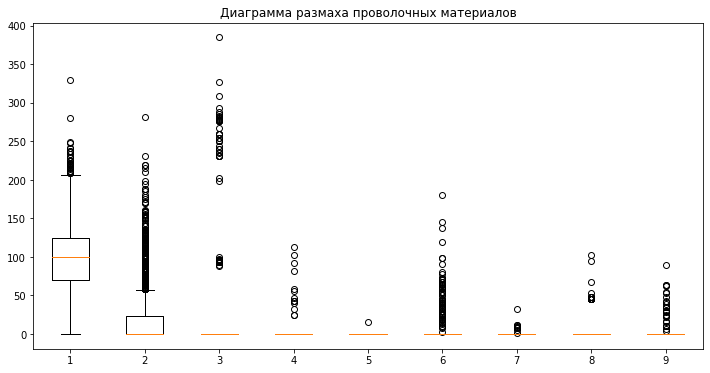

In [143]:
plt.figure(figsize=(12,6))
plt.boxplot(x=data_wire_new.iloc[:, 1:16])
plt.title('Диаграмма размаха проволочных материалов')
plt.show()

In [144]:
data_wire_new = data_wire_new[data_wire_new['wire_1']<300]
data_wire_new = data_wire_new[data_wire_new['wire_2']<250]

Таблицу data_wire_time_new предобрабатывать не будем, поскольку она не понадобится для обучения моделей.

### Предварительный вывод по анализу и предобработке данных и  дальнейший план работы ###

В ходе анализа данных мы загрузили и изучили все таблицы, а именно:
- переименовали все столбцы и привели их к змеиному регистру;
- привели все столбцы с датами к datetime64;
- удалили аномалии;
- построили гистограммы и диаграммы размаха для наших будущих признаков, проанализировали их;
- заполнили пропуски нулями в таблицах data_bulk_new и data_wire_new, а также построили столбчатые диаграммы;
- предварительно выделили целевой признак *pre_target* (последний замер температуры партии);
- выделили отдельно признак с замером первой температуры.


Дальнейший план:
- объединить все признаки по ключу *key*, если какие-то партии будут с неполными данными - отбросим их на этапе объединения;
- в целевом признаке сохраним только те значения температур партий, которые останутся в фичах;
- разделим данные на train и test 3:1;
- и дальше будем перебирать гиперпараметры разных моделей с помощью pipeline + gridsearch;
- Качество модели оцениваем по метрике МАЕ;
- выбрав лучшую модель, протестируем ее на тестовой выборке, минимальный порог MAE = 6.8.

## Работа с признаками ##

### Создание новых признаков ###

Итак, сначала создадим новые признаки. Вернемся к нашей таблице *data_temp_new*, чтобы расчитать разницу между последним и первым измерением температуры, т.е. получим время плавки стали.

In [145]:
data_temp_time = sub_data_temp_new.groupby('key', as_index=False).agg(start_time=('measurement_time', 'first'), last_time=('measurement_time', 'last'))

In [146]:
data_temp_time['time'] = ((data_temp_time['last_time'] - data_temp_time['start_time']).dt.total_seconds()).astype('int')

In [147]:
data_temp_time = data_temp_time.drop(['start_time', 'last_time'], axis=1)
data_temp_time.head()

,key,time
0,1,1714
1,2,1265
2,3,1753
3,4,1220
4,5,1536


Теперь вернемся к таблице *data_arc_new*, сложим значения каждой из мощностей по каждой партии и посмотрим, насколько мощности коррелируют друг с другом.

In [148]:
data_arc_temp = data_arc_new.groupby('key', as_index=False).agg(active_power=('active_power', 'sum'), reactive_power=('reactive_power', 'sum'))

In [149]:
data_arc_temp.head(10)

,key,active_power,reactive_power
0,1,3.036730,2.142821
1,2,2.139408,1.453357
2,3,4.063641,2.937457
3,4,2.706489,2.056992
4,5,2.252950,1.687991
5,6,2.725274,1.881313
6,7,2.626877,1.960419
7,8,2.678958,2.096952
8,9,3.520820,2.527365
9,10,3.118778,2.154941


In [150]:
data_arc_temp.corr()

,key,active_power,reactive_power
key,1.000000,-0.031374,-0.034565
active_power,-0.031374,1.000000,0.992518
reactive_power,-0.034565,0.992518,1.000000


Прослеживается сильная зависимость между мощностями, поэтому добавим значение полной мощности, остальные уберем.

In [151]:
data_arc_temp['full_power'] = ((data_arc_temp['active_power'])**2 + (data_arc_temp['reactive_power'])**2)**0.5

In [152]:
data_arc_temp = data_arc_temp.drop(['active_power', 'reactive_power'], axis=1)
data_arc_temp.head()

,key,full_power
0,1,3.716640
1,2,2.586371
2,3,5.014163
3,4,3.399456
4,5,2.815155


### Объединение признаков ###

Объединим признаки в общую таблицу по номеру партии *key*, затем изучим информацию по нашей итоговой таблице.


Нам понадобятся таблицы: data_arc_temp, data_temp_time, data_bulk_new, data_gas_new, data_temp, data_wire_new

In [153]:
full_data = data_arc_temp.merge(
    data_temp_time, on='key', how='inner').merge(
    data_bulk_new, on='key', how='inner').merge(
    data_gas_new, on='key', how='inner').merge(
    data_temp, on='key', how='inner').merge(
    data_wire_new, on='key', how='inner')

In [154]:
show_all_info(full_data)

Первые 10 строк:


,key,full_power,time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,last_temp,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,3.716640,1714,0,0,0,43,0,0,0,...,1613,60,0,0,0,0,0,0,0,0
1,2,2.586371,1265,0,0,0,73,0,0,0,...,1602,96,0,0,0,0,0,0,0,0
2,3,5.014163,1753,0,0,0,34,0,0,0,...,1599,91,0,0,0,0,0,0,0,0
3,4,3.399456,1220,0,0,0,81,0,0,0,...,1625,89,0,0,0,0,0,0,0,0
4,5,2.815155,1536,0,0,0,78,0,0,0,...,1602,89,9,0,0,0,0,0,0,0
5,6,3.311564,1497,0,0,0,117,0,0,0,...,1596,99,9,0,0,0,0,0,0,0
6,7,3.277762,1744,0,0,0,117,0,0,0,...,1599,98,0,0,0,0,0,0,0,0
7,8,3.402062,1615,0,0,0,99,0,0,0,...,1598,155,0,0,0,0,0,0,0,0
8,9,4.334022,1811,0,0,0,117,0,0,0,...,1592,113,9,0,0,0,0,0,0,0
9,10,3.790850,1551,0,0,0,0,0,0,0,...,1593,81,12,0,0,0,0,0,0,0


Основная информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2321 entries, 0 to 2320
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2321 non-null   int64  
 1   full_power  2321 non-null   float64
 2   time        2321 non-null   int64  
 3   bulk_1      2321 non-null   int64  
 4   bulk_2      2321 non-null   int64  
 5   bulk_3      2321 non-null   int64  
 6   bulk_4      2321 non-null   int64  
 7   bulk_5      2321 non-null   int64  
 8   bulk_6      2321 non-null   int64  
 9   bulk_7      2321 non-null   int64  
 10  bulk_8      2321 non-null   int64  
 11  bulk_9      2321 non-null   int64  
 12  bulk_10     2321 non-null   int64  
 13  bulk_11     2321 non-null   int64  
 14  bulk_12     2321 non-null   int64  
 15  bulk_13     2321 non-null   int64  
 16  bulk_14     2321 non-null   int64  
 17  bulk_15     2321 non-null   int64  
 18  gas         2321 non-null   float64
 19  start_

None

Количество уникальных значений key: 2321
Описательная статистика:


,key,full_power,time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,last_temp,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,2321.000000,2321.000000,2321.000000,2321.000000,2321.000000,2321.000000,2321.000000,2321.000000,2321.000000,2321.000000,...,2321.000000,2321.000000,2321.000000,2321.000000,2321.000000,2321.0,2321.000000,2321.000000,2321.000000,2321.000000
mean,1251.906506,3.876890,2314.237829,3.320551,1.171047,47.098234,37.324429,2.274451,22.231797,1.662215,...,1593.366221,102.244722,17.332184,3.161568,0.282637,0.0,0.928479,0.006032,0.291254,0.316243
std,714.422616,1.506680,1374.097134,11.780600,17.002701,75.014337,58.706806,18.341095,54.925495,28.351300,...,11.157237,43.130720,32.896893,27.839042,4.611296,0.0,8.466570,0.196867,4.286462,3.445879
min,1.000000,0.331897,270.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1541.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,631.000000,2.841651,1579.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1587.000000,73.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1254.000000,3.764704,2045.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1593.000000,101.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1868.000000,4.763514,2781.000000,0.000000,0.000000,79.000000,78.000000,0.000000,0.000000,0.000000,...,1598.000000,128.000000,23.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,2499.000000,15.272257,23674.000000,94.000000,282.000000,454.000000,281.000000,293.000000,407.000000,772.000000,...,1653.000000,280.000000,231.000000,385.000000,113.000000,0.0,180.000000,8.000000,102.000000,62.000000


Количество пропусков:


key           0
full_power    0
time          0
bulk_1        0
bulk_2        0
bulk_3        0
bulk_4        0
bulk_5        0
bulk_6        0
bulk_7        0
bulk_8        0
bulk_9        0
bulk_10       0
bulk_11       0
bulk_12       0
bulk_13       0
bulk_14       0
bulk_15       0
gas           0
start_temp    0
last_temp     0
wire_1        0
wire_2        0
wire_3        0
wire_4        0
wire_5        0
wire_6        0
wire_7        0
wire_8        0
wire_9        0
dtype: int64

Количество дубликатов: 0



Получили в итоге 2324 партии. Далее попробуем сначала разбить данные на тренировочную и тестовую выборки, потом попробуем найти наиболее информативные признаки.

### Разбиение данных на train и test ###

In [155]:
features = full_data.drop(['last_temp', 'key'], axis=1)
target = full_data['last_temp']

In [156]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

In [157]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(1740, 28)
(581, 28)
(1740,)
(581,)


### Сортировка признаков по степени их важности ###

Построим столбчатую диаграмму важности признаков, обучив модель CatBoostRegressor.

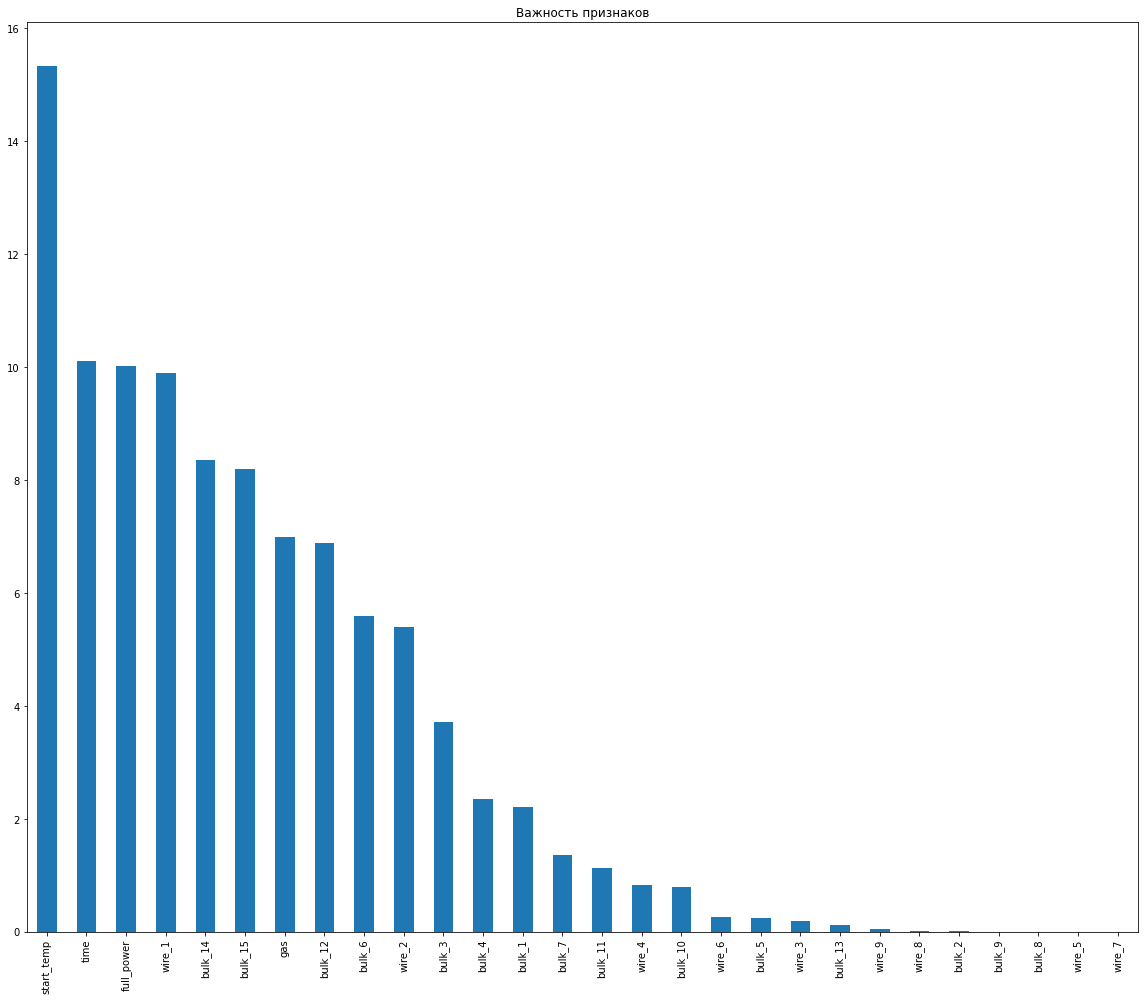

In [158]:
model_cat = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE)
model_cat.fit(features_train, target_train)

cat_imp = pd.Series(model_cat.get_feature_importance(), features_train.columns)
fig, ax = plt.subplots(figsize=(16,14))
cat_imp.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Важность признаков")
fig.tight_layout()

In [159]:
cat_imp.sort_values(ascending=False)

start_temp    15.331086
time          10.098963
full_power    10.012437
wire_1         9.888013
bulk_14        8.356730
bulk_15        8.186987
gas            6.995550
bulk_12        6.878396
bulk_6         5.586310
wire_2         5.388583
bulk_3         3.709692
bulk_4         2.345407
bulk_1         2.201527
bulk_7         1.365705
bulk_11        1.131510
wire_4         0.830607
bulk_10        0.792171
wire_6         0.267756
bulk_5         0.242496
wire_3         0.188940
bulk_13        0.125371
wire_9         0.048207
wire_8         0.015508
bulk_2         0.012009
bulk_9         0.000039
bulk_8         0.000000
wire_5         0.000000
wire_7         0.000000
dtype: float64

Итак, самыми информативными признаками оказались start_temp (стартовая температура плавления), time (время плавки), full_power (полная мощность), а также признаки wire_1, bulk_14, bulk_15, gas, bulk_12, bulk_6, wire_2.

Самыми бесполезными признаками оказались wire_7, wire_5, bulk_8, bulk_9, чуть менее беспозелные - bulk_2, wire_8, wire_9.

Теперь посмотрим на кореляцию между полученными признаками.

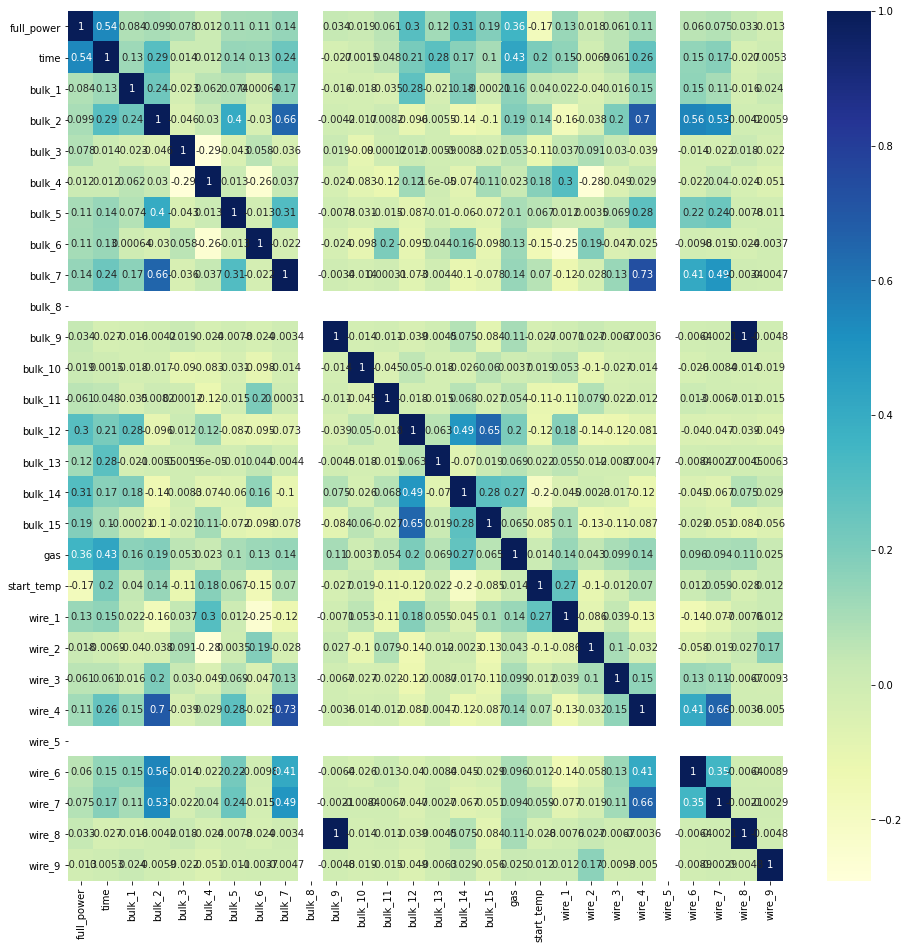

In [160]:
plt.figure(figsize=(16,16))
dataplot = sns.heatmap(features_train.corr(), cmap="YlGnBu", annot=True)
plt.show()

По полученной карте выше отбросим следующие признаки:
- wire_5 и bulk_8, поскольку они вообще ни с чем не связаны (помним, что они использовались только по 1му разу);
- wire_4 сильно коррелирует с bulk_7, bulk_2 и wire_7, уберем их всех, учитывая их бесполезность;
- bulk_9 и wire_8 очень сильно коррелируют (0.99), отбросим оба;
- bulk_12 и bulk_15 также имеют некоторую корреляцию (0.64), но не будем их трогать, поскольку в отличие от материалов выше, эти два материала использовались довольно часто. Можно предположить, что они используются вместе, например, для одновременного участия в реакции.

In [161]:
features_train_fin = features_train.drop(['wire_5', 'bulk_8', 'bulk_7', 'bulk_2', 'bulk_9', 'wire_8', 'wire_7'], axis=1)
features_test_fin = features_test.drop(['wire_5', 'bulk_8', 'bulk_7', 'bulk_2', 'bulk_9', 'wire_8', 'wire_7'], axis=1)

Снова посмотрим на корреляцию признаков.

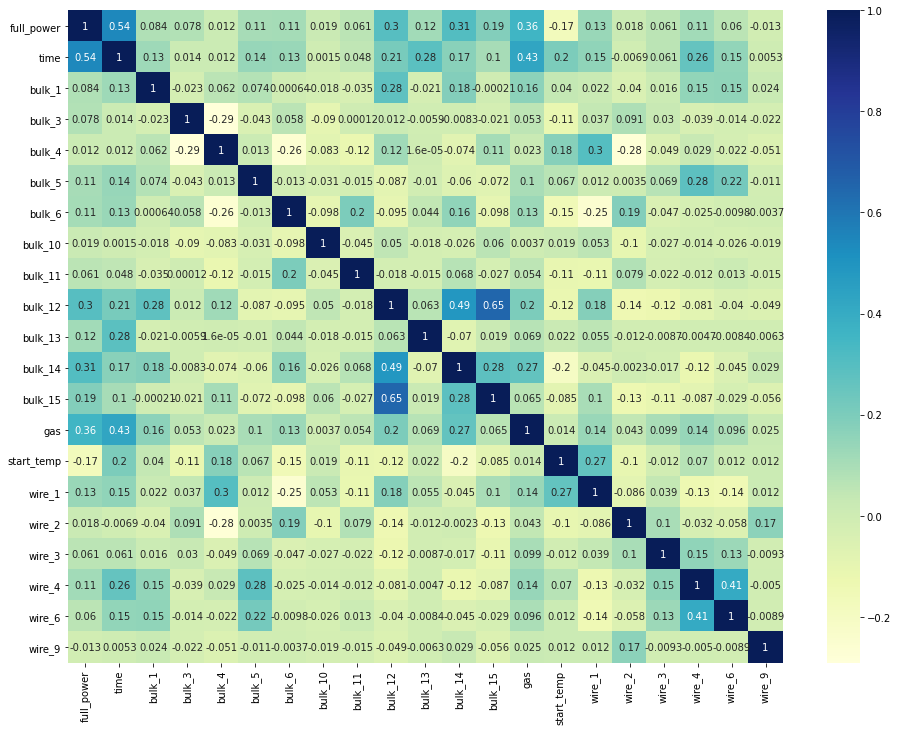

In [162]:
plt.figure(figsize=(16,12))
dataplot = sns.heatmap(features_train_fin.corr(), cmap="YlGnBu", annot=True)
plt.show()

Признаки выглядят гораздо лучше.

**Вовод**:

- создали 2 новых признака: время плавки time и полная мощность full_power;
- провели объединение наших данных по номеру партии, оставив при этом только те партии, по которым есть вся информация;
- выделили целевой признак и разбили наши данные на тренировочную и тестовую выборку в соотношении 3:1;
- изучили корреляцию между полученными признаками и удалили признаки, обладающие высокой корреляцией.

## Обучение моделей ##

Обучим несколько моделей, используя перебор гиперпараметров и pipeline.

### Ridge регрессия ###

In [163]:
model_ridge = Ridge(random_state=RANDOM_STATE)

In [164]:
pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model_ridge', model_ridge)])

In [165]:
param_r = {'model_ridge__alpha': [0, 0.01, 0.1, 0.5, 1, 100]}

In [166]:
grid_r = GridSearchCV(pipe_ridge, param_grid=param_r, cv=10, n_jobs=-1, scoring= 'neg_mean_absolute_error')
grid_r.fit(features_train_fin, target_train)
print(grid_r.best_params_)
print(grid_r.best_score_)

{'model_ridge__alpha': 100}
-7.021243139731439


### Catboost

In [167]:
model_cbr = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE)

In [85]:
pipe_cbr = Pipeline([
    ('scaler', StandardScaler()),
    ('model_cbr', model_cbr)])

In [86]:
param_cbr = {'model_cbr__depth' : [2,4,6,8,10,12],
             'model_cbr__learning_rate' : [0.01, 0.05, 0.1, 1],
             'model_cbr__n_estimators': [50, 100, 150, 200] }

In [87]:
model_cbr = GridSearchCV(pipe_cbr, param_grid=param_cbr, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=False)
model_cbr.fit(features_train_fin, target_train)
print(model_cbr.best_params_)
print(model_cbr.best_score_)

{'model_cbr__depth': 6, 'model_cbr__learning_rate': 0.1, 'model_cbr__n_estimators': 100}
-6.7775383228089865


### XGBoost

In [88]:
model_xgb = XGBRegressor(random_state=RANDOM_STATE)

In [89]:
pipe_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model_xgb', model_xgb)])

In [90]:
param_xgb = {'model_xgb__n_estimators':[30, 50, 100, 150,200,300],
             'model_xgb__learning_rate':[0.1, 0.01, 0.001, 1],
             'model_xgb__max_depth':[2,4,6,8]}

In [ ]:
model_xgb = GridSearchCV(pipe_xgb, param_grid=param_xgb, n_jobs=-1, scoring='neg_mean_absolute_error')
model_xgb.fit(features_train_fin, target_train)
print(model_xgb.best_params_)
print(model_xgb.best_score_)

### SGD

In [ ]:
model_sgd = SGDRegressor(random_state=RANDOM_STATE)

In [ ]:
pipe_sgd = Pipeline([
    ('scaler', StandardScaler()),
    ('model_sgd', model_sgd)])

In [ ]:
param_sgd = [{
        'model_sgd__max_iter':[1000, 10000, 100000, 1000000],
        'model_sgd__tol':[1e-10, 1e-3],
        'model_sgd__eta0':[0.001, 0.01]}]

In [ ]:
model_sgb = GridSearchCV(pipe_sgd, param_grid=param_sgd, n_jobs=-1, scoring='neg_mean_absolute_error')
model_sgb.fit(features_train_fin, target_train)
print(model_sgb.best_params_)
print(model_sgb.best_score_)

Итак, нашей лучшей моделью оказалась Catboost при следующих гиперпараметрах depth = 6, learning_rate = 0.1, n_estimators=100. Проверим нашу модель на тестовой выборке и сравним ее с константной моделью.

## Проверка лучшей модели

In [168]:
model_cb = CatBoostRegressor(depth = 6, learning_rate = 0.1, n_estimators=100, verbose=False, random_state=RANDOM_STATE)

In [169]:
model_cb.fit(features_train_fin, target_train)
predictions_cb = model_cb.predict(features_test_fin)
mae = mean_absolute_error(target_test, predictions_cb)
print('MAE лучшей модели CatBoostRegressor', mae)

MAE лучшей модели CatBoostRegressor 6.598376742642019


Сравним результат с константной моделью.

In [170]:
dummy_model = DummyRegressor()

In [171]:
dummy_model.fit(features_train_fin, target_train)
predictions_dummy = dummy_model.predict(features_test_fin)
mae_dummy = mean_absolute_error(target_test, predictions_dummy)
print('MAE для константной модели', mae_dummy)

MAE для константной модели 7.6230755534453145


**Вывод**:
мы обучили несколько моделей и нашли лучшую из них, ей оказалась модель **Catboost** при следующих гиперпараметрах: learning_rate = 0.1, depth = 6, n_estimators=100.


**MAE** на тестовой выборке для лучшей модели составил **6.5983**, при этом **MAE** для константной модели **7.6230**. Мы добились необходимого результата по MAE < 6.8.


# Отчёт по решению

**Целью** данной работы была разработка модели, которая предсказывает конечную температуру расплава стали, для оптимизации затрат на металлургическом комбинате.

В ходе проделанной работы были загружены и проанализированы все имеющиеся у нас данные. Данные состояли из файлов, полученных из разных источников:
- **data_arc_new.csv** — данные об электродах;
- **data_bulk_new.csv** — данные о подаче сыпучих материалов (объём);
- **data_bulk_time_new.csv** — данные о подаче сыпучих материалов (время);
- **data_gas_new.csv** — данные о продувке сплава газом;
- **data_temp_new.csv** — результаты измерения температуры;
- **data_wire_new.csv** — данные о проволочных материалах (объём);
- **data_wire_time_new.csv** — данные о проволочных материалах (время).


Была проведена предобработка данных, а именно:
- была написана специальная функция, позволяющая получить полную информацию по всем таблицам;
- все столбцы во всех таблицах были переименованы и приедены к змеиному регистру;
- все столбцы с датами привели к типу datetime, столбцы с целочисленными данными - к init;
- по всем данным были построены гистограммы и диаграммы размаха, их детальных анализ помог найти нам различные закономерности и аномалии;
- нашли и удалили аномалии в таблицах с реактивной мощностью, добавлению сыпучих и проволочных материалов, продувке газом, а также из замеров температур;
- были обработаны пропуски в таблицах data_bulk_new и data_wire_new (заполнили их нулями), а также построили столбчатые диаграммы по частоте их использования;
- из таблицы по замерам температуры были удалены все пропуски и оставлены только те партии, где есть хотя бы 2 замера;
- затем оставить только начальное и конечное значение замеров температуры, остальные значения отбросили;
- выделили целевой признак - конечный замер температуры;
- выделили отдельно признак с замером первой температуры.

В процессе работы с признаками была проделана следующая работа:
- выделили отдельный признак - время плавки стали, рассчитав его как разницу между последним и первым измерением температуры;
- сагрегировали значения активной и реактивных мощностей по каждой, затем рассчитали из полученных данных отдельный признак - полная мощность, при этом данные по активной и реактивной мощности отбросили;

После этого мы объединили все признаки в общую таблицу по номеру партии key и изучим информацию по нашей итоговой таблице, отбросив при этом все партии, имеющие не полную информацию по всем признакам. В итоге мы получили 2324 партии. Далее мы разбили данные на тренировочную и тестовую выборки в соотношении 75:25, выделили фичи и целевой признак.


Затем мы провели сортировку признаков по степени их важности, для этого построили столбчатую диаграмму важности признаков. Выяснили что самыми информативными признаками оказались start_temp (стартовая температура плавления), time (время плавки), full_power (полная мощность), а также признаки wire_1, bulk_14, bulk_15, gas, bulk_12, bulk_6, wire_2. Ниже приведены топ-15 самых значимых признаков с коэффициентами значимости:
- **start_temp**:    15.331086
- **time**:          10.098963
- **full_power**:    10.012437
- **wire_1**:         9.888013
- **bulk_14**:        8.356730
- **bulk_15**:        8.186987
- **gas**:            6.995550
- **bulk_12**:        6.878396
- **bulk_6**:         5.586310
- **wire_2**:         5.388583
- **bulk_3**:         3.709692
- **bulk_4**:         2.345407
- **bulk_1**:         2.201527
- **bulk_7**:         1.365705
- **bulk_11**:        1.131510

У остальных признаков коэффициент значимости оказался ниже единицы. Самыми бесполезными признаками оказались wire_7, wire_5, bulk_8, bulk_9, чуть менее беспозелные - bulk_2, wire_8, wire_9.

Затем мы построили карту корреляции между признаками. По полученным данным отбросили следующие признаки: wire_5, bulk_8, wire_4, bulk_7, bulk_2, wire_7, bulk_9 и wire_8.

После полной подготовки данных мы обучили несколько моделей, используя перебор гиперпараметров gridsearch и pipeline. Были обучены модели Ridge-регрессии, Catboostregressor, XGBRegressor и SGDRegressor. Самой лучшей моделью оказалась Catboostregressor при следующих гиперпараметрах depth = 6, learning_rate = 0.1, n_estimators=100,  **MAE** на тренировочной выборке оказался равен **6.7775**.

После этого мы проверили нашу лучшую модель на тестовой выборке и сравнили ее с константной моделью. **MAE** на тестовой выборке для лучшей модели составил **6.5983**, при этом **MAE** для константной модели **7.6230**. Мы добились необходимого результата по MAE < 6.8.

В ходе работы мы столкнулись со следующими трудностями:
1. Аномалии в данных. Нам встретились: отрицательное значение реактивной энергии (**-715.479924**) у партии 2116, котрую мы целиком отбросили. Также мы отбросили все аномалии по продувке газом, значение которых было >50, аномалии в сыпучих материалах: bulk_12>1500 и bulk_5>500 и аномалии в проволочных материалах: wire_1>300 и wire_2>250.
2. Большое количество пропусков в данных по сыпучим и проволочным материалам.
3. Высокая корреляция между некоторыми признаками. Например, активная и реактивная мощности имеют коэффициент корреляции 0.99, поэтому пришлось выделить новый признак полная мощность, а активную и реактивную отбросить.
4. Низкая значимость некоторых признаков. Например коэффициенты значимости признаков bulk_9, bulk_8, wire_5, wire_7 равны нулю.
5. Сложность выделения целевого признака. Не сразу было понятно, какую именно температуру нужно будет предсказывать.
6. Сложность при обучении моделей. Чтобы избежать утечки данных мы использовали pipeline при обучении наших моделей.